In [390]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time
from scipy.linalg import eigh
from collections import defaultdict
from scipy.optimize import curve_fit

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

# Inputs
## Default values

In [425]:
species = "Rb87" # "Rb87", "K40"

# lattice parameters
# V1064Er = 5.            # 1064 lattice depth, in 1064 recoil energy
# V532Er = 3.             # 532 lattice depth, in 532 recoil energy
V1064Er = 25.213063 / 2.02781   # 25.213063
V532Er = 35.517929 / 8.11125    # 35.517929
n0nom = 0               # peak density
# The superlattice phase that determines the relative position between 1064 and 532 lattice
# 532 lattice is fixed at 0, so changing the pase by pi for 1064 restores the original lattice
phi12, phi23 = 0., 0.
# phi12, phi23 = np.pi*1/3, -np.pi*1/3    # decorated triangular lattice
phi12, phi23 = np.pi*1/12, -np.pi*1/12    # decorated triangular lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 6             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 5         # inclusive
q_in = np.array([0., 0.])

## Scan parameter (don't just run from here!)
If you have done some other scans, the scanned parameter will be left at the last value of the previous scans.

In [426]:
# Options: 'V1064Er', 'V532Er', 'phi12', 'phi23', 
#          'B1_rel_int_1064', 'B1_rel_int_532', 'B3_rel_int_1064', 'B3_rel_int_532'
scan_param = 'B1_rel_int_1064'

# Define the range to scan for your chosen parameter
# For some of the scans, I need to run bsc.find_H_components for each scan value
flag_recompute_H_components = True
if scan_param in ['V1064Er', 'V532Er']:
    param_values = np.linspace(5., 20., 50)
    flag_recompute_H_components = False
elif scan_param in ['phi12', 'phi23']:
    param_values = np.linspace(-0.1 * np.pi, 0.1 * np.pi, 50)
    # param_values = np.linspace(0., np.pi, 50)
elif scan_param in ['B1_rel_int_1064', 'B1_rel_int_532', 'B3_rel_int_1064', 'B3_rel_int_532']:
    param_values = np.linspace(0.8, 1.2, 50)
else:
    raise ValueError(f"Unknown parameter: {scan_param}")

# Initialization
## Units

In [427]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
    Er_1064 = E9c.E_r1064_Rb87
    Er_532 = E9c.E_r532_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
    Er_1064 = E9c.E_r1064_K40
    Er_532 = E9c.E_r532_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532nom = V532Er * Er_532 / E9c.hnobar / 1e3       # in kHz (i.e. V_SI / hbar / 1e3 / 2pi), assuming that polarizability is accounted for correctly
V1064nom = V1064Er * Er_1064  / E9c.hnobar / 1e3   # Note that setting this to 0 doesn't give you a proper band structure of 532 nm lattice, since you are now
                                # considering too many plane waves that don't actually contribute.
V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [428]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in

In [429]:
def MinimumGap(e_values, band1, band2):
    """Prints the position and energy of the minimum gap.
    
    Example: MinimumGap(e_values,2,3)
    Should be slightly enhanced to return something
    """
    gaps = e_values[:, band2] - e_values[:, band1]
    print('The minimum band gap between band{} and band{} is {} kHz, happening at the {} (python index) q evaluated' \
          .format(band1, band2, gaps.min() * f_unit / 1e3 / (2 * np.pi), gaps.argmin()))

def find_q_geo_tensor(n_q, n_band, Exp_lib, q_list, E_list, psi_list, Hq_mmat, Hq_nmat, component = 'xx'):
    """Find the quantum geometric tensor for a given Bloch state psi."""
    q = q_list[n_q]
    psin = psi_list[n_q, :, n_band]
    En = E_list[n_q, n_band]
    dH1 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[0])
    dH2 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[1])
    qgt = 0j
    for m_band in range(E_list.shape[1]):
        if m_band == n_band:
            continue
        psim = psi_list[n_q, :, m_band]
        Em = E_list[n_q, m_band]
        qgt += psim.conj() @ dH1 @ psin * psin.conj() @ dH2 @ psim / (Em - En)**2
    if not util.IsHermitian(qgt):
        logging.warning(f"Quantum geometric tensor for n_band {n_band}, n_q {n_q} is not Hermitian")
    return qgt

# Real space plots

Pretty sure that the orientation is still wrong - maybe flipped about $x = 0$?

In [430]:
bool_plot_real = True
x_real = np.linspace(-1, 1, 500) * 1e-6
y_real = np.linspace(-1.1, 1.1, 500) * 1e-6

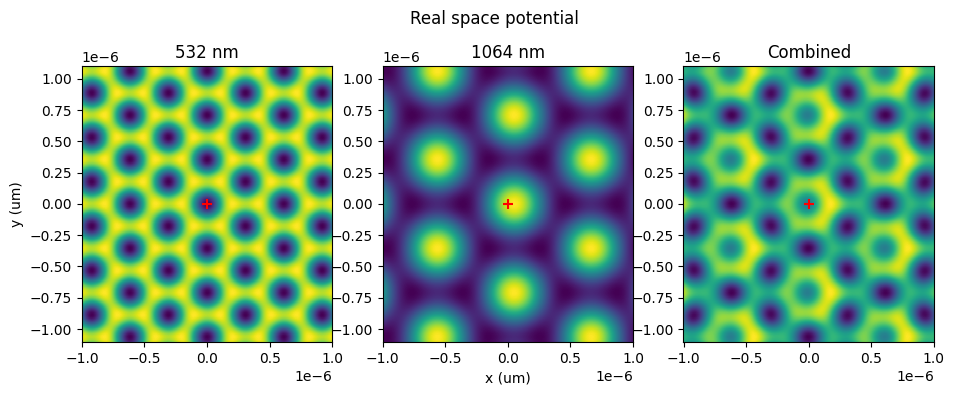

In [431]:
pos_delta = E9c.a_lw_hex * E9c.k1k * (phi12 / 2 / np.pi) + E9c.a_lw_hex * E9c.k3k * (phi23 / 2 / np.pi)
x_delta, y_delta = pos_delta # should be simple functions of phi12 and phi23
V_532_real = bsc.get_Vin(x_real, y_real, V532, B1_rel_int_532, B3_rel_int_532, 0, 0, 1)
V_1064_real = - bsc.get_Vin(x_real, y_real, V1064, B1_rel_int_1064, B3_rel_int_1064, x_delta, y_delta, 2)
V_super_real = V_532_real + V_1064_real
fig_real = plt.figure(figsize = (11, 4))
ax_532 = fig_real.add_subplot(131, aspect = "equal")
ax_1064 = fig_real.add_subplot(132, aspect = "equal")
ax_super = fig_real.add_subplot(133, aspect = "equal")
fig_real.suptitle("Real space potential")
ax_532.set_ylabel("y (um)")
ax_1064.set_xlabel("x (um)")
if bool_plot_real:
    for ax, V_real, ax_title in zip([ax_532, ax_1064, ax_super],
                                    [V_532_real, V_1064_real, V_super_real],
                                    ["532 nm", "1064 nm", "Combined"]):
        im = ax.pcolormesh(x_real, y_real, V_real, cmap = 'viridis')
        ax.scatter(0, 0, color = 'red', marker = '+', s = 50)
        ax.set_title(ax_title)
        # fig_real.colorbar(im, ax = ax)
    

# Finding Bloch states and band energies

Total number of points = 50
--- 3.8587677478790283 seconds ---


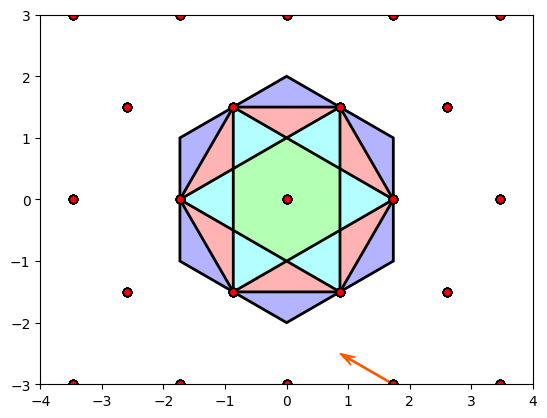

In [432]:
start_time = time.time()

# Generate qset
e_values = np.zeros((len(param_values), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(param_values), size**2, bandnum), dtype = np.cdouble)
e_states_ni = [[] for _ in range(bandnum)]  # a list of blochstate for each band

# find non-interacting solution
print("Total number of points = {0}".format(len(param_values)))
ax_BZ = bsc.PlotBZSubplot()
bsc.plot_qset(ax_BZ, qset = q_in)
if not flag_recompute_H_components: # One component set fits all
    Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)

for i, param_val in enumerate(param_values):
    # Override the scanned parameter
    if scan_param == 'V1064Er':
        V1064Er = param_val
        V1064nom = V1064Er * Er_1064  / E9c.hnobar / 1e3
        V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
    elif scan_param == 'V532Er':
        V532Er = param_val
        V532nom = V532Er * Er_532 / E9c.hnobar / 1e3
        V532 = 2 * np.pi * V532nom * 1e3 / f_unit
    elif scan_param == 'phi12':
        phi12 = param_val
    elif scan_param == 'phi23':
        phi23 = param_val
    elif scan_param == 'B1_rel_int_1064':
        B1_rel_int_1064 = param_val
    elif scan_param == 'B1_rel_int_532':
        B1_rel_int_532 = param_val
    elif scan_param == 'B3_rel_int_1064':
        B3_rel_int_1064 = param_val
    elif scan_param == 'B3_rel_int_532':
        B3_rel_int_532 = param_val
    
    Exp_lib = {"species": species, "units_dict": all_units_dict,
               'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064,
               'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064,
               'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064,
               'n0nom': n0nom, 'n0': n0,
               'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064,
               'phi12': phi12, 'phi23': phi23}
    
    if flag_recompute_H_components: # New component set for each scan value
        Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)
    H = bsc.find_H(q_in, Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    e_values[i,:], e_states[i,:,:] = eigh(H, eigvals = (bandstart, bandend),
                                          overwrite_a = True, check_finite = False)
    for j, bandN in enumerate(range(bandstart, bandend + 1)):
        e_states_ni[j].append(bsc.blochstate(e_states[i,:,j], q = q_in, center = k_center, N = bandN, E = e_values[i,j], param = Exp_lib))

print("--- {0} seconds ---".format((time.time() - start_time)))

In [433]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
else:
    e_values = e_values.astype(np.double)

C:\Users\ken92\AppData\Local\Temp\ipykernel_32920\871142045.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


# Plots
## Band energy evolution

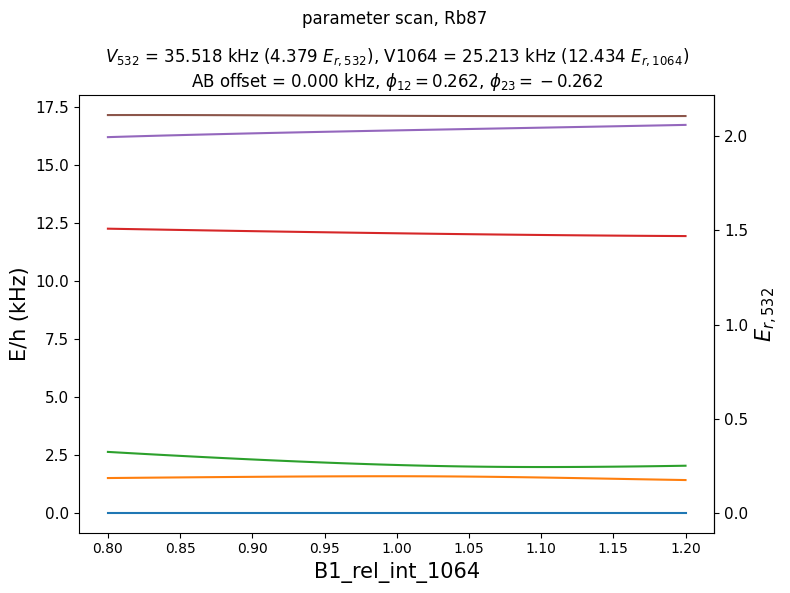

In [434]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values, axis = 1)
E_kHz_offset = (e_values - E_lowest[:,np.newaxis]) * f2kHz
E_kHz_highest = np.max(E_kHz_offset, axis = 0)
fig_E = plt.figure(0, figsize=(8,6))
fig_E.clf()

ax_E = fig_E.add_subplot(111)
for i in range(bandnum):
    E_plot_kHz = (e_values.transpose()[i] - E_lowest) * f2kHz
    ax_E.plot(param_values, E_plot_kHz, '-', label = 'Non-interacting' + str(i + bandstart))
ryax = ax_E.secondary_yaxis('right', functions = (lambda x: x / (f2kHz * 2 * np.pi**2), lambda x: x * (f2kHz * 2 * np.pi**2)))
ryax.set_ylabel(r"$E_{r,532}$", fontsize = 15)
ryax.tick_params(axis = 'y', labelsize = 11)
ax_E.set_xlabel(scan_param, fontsize = 15)
ax_E.set_ylabel('E/h (kHz)', fontsize = 15)
ax_E.tick_params(axis = 'y', labelsize = 11)
ax_E.set_title((rf'$V_{{532}}$ = {V532nom:.3f} kHz (${V532Er:.3f}\ E_{{r, 532}}$), V1064 = {V1064nom:.3f} kHz (${V1064Er:.3f}\ E_{{r, 1064}}$)'
                '\n'
                rf'AB offset = {float(ABoffset1064nom):.3f} kHz, $\phi_{{12}} = {phi12:.3f}$, $\phi_{{23}} = {phi23:.3f}$'))

fig_E.suptitle(f'parameter scan, {species}')
fig_E.tight_layout()

## Bloch state
### Population in each peak


In [435]:
color_B12 = np.array([1, 0, 0])      # Colors in an array of [R, G, B] for easier numerical manipulation
color_B23 = np.array([0, 1, 0])
color_B13 = np.array([0, 0, 1])
color_center = np.array([0, 0, 0])
color_else = np.array([0, 0, 0])
# This is arranged in the order of [G1, G2, G3]
all_colors = np.vstack([color_B23, color_B13, color_B12])

dict_diff_order = {
    "center": np.array([0, 0, 0]),
    "G1_1st": np.array([1, 0, 0]),
    "G2_1st": np.array([0, 1, 0]),
    "G3_1st": np.array([0, 0, 1]),
    "G1_2nd": np.array([2, 0, 0]),
    "G2_2nd": np.array([0, 2, 0]),
    "G3_2nd": np.array([0, 0, 2]),
    "G1_G2": np.array([1, -1, 0]),  # This is G1_1st - G2_1st; other pairs follows similarly
    "G2_G3": np.array([0, 1, -1]),
    "G3_G1": np.array([-1, 0, 1]),
}

hw_mn = np.array([E9c.k_lw * 0.3, E9c.k_lw * 0.3])    # half width of the box that encloses each peak

Visualize the peak that I'm looking at with one of the state.

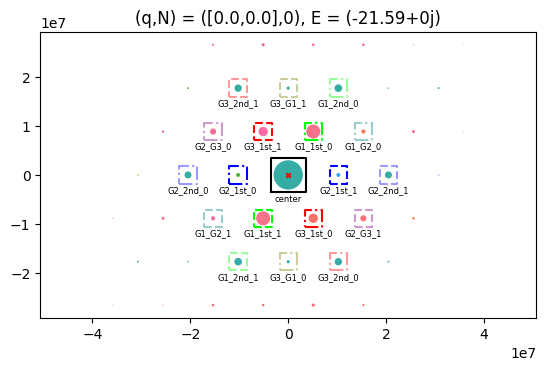

In [436]:
dict_color_pairs = {"center": color_center, "everything else": color_else}
psi_gs = e_states_ni[0][0] # Need to fix this ugly code at some point
ax_gs = bsc.ToFSubplot(psi_gs)

# center peak
util.plot_rectangle(ax_gs, center = psi_gs.q, half_widths = hw_mn * 2,
                    color = color_center, ls = "-")
ax_gs.text(psi_gs.q[0], psi_gs.q[1] - E9c.k_lw * 0.9, 'center',
            fontsize = 6, horizontalalignment = 'center', color = 'k')

# diffraction peaks
for label_pair, diff_order in dict_diff_order.items():
    if label_pair == "center": continue
    m_diff = diff_order[0] - diff_order[2]
    n_diff = diff_order[1] - diff_order[2]

    num_of_diff = abs(diff_order).sum()
    color = abs(diff_order) @ all_colors / num_of_diff
    dict_color_pairs[label_pair] = color
    alpha = 1 - np.sqrt(num_of_diff - 1) * 0.6

    for i_pk, ls_pk in zip([0, 1], ["-.", "--"]):
        vec = ((m_diff + psi_gs.q[0]) * E9c.G1 +
               (n_diff + psi_gs.q[1]) * E9c.G2) * (-1)**i_pk
        util.plot_rectangle(ax_gs, center = vec, half_widths = hw_mn,
                            color = color, alpha = alpha, ls = ls_pk)
        ax_gs.text(vec[0], vec[1] - E9c.k_lw * 0.6, label_pair + f'_{i_pk}',
                   fontsize = 6, horizontalalignment = 'center', color = 'k')

Look at the sum / difference in population in each pairs for each of the states.

In [437]:
pop_in_peaks_list = [defaultdict(float) for _ in param_values]
pop_in_pairs_list = [defaultdict(float) for _ in param_values]
pop_diff_in_pairs_list = [defaultdict(float) for _ in param_values]

# center peak
for i_scan, _ in enumerate(param_values):
    pop = abs(e_states_ni[0][i_scan].mnasindex(0, 0))**2
    pop_in_peaks_list[i_scan]["center"] += pop
    pop_in_pairs_list[i_scan]["center"] += pop

# diffraction peaks
for label_pair, diff_order in dict_diff_order.items():
    if label_pair == "center": continue
    m_diff = diff_order[0] - diff_order[2]
    n_diff = diff_order[1] - diff_order[2]

    for i_scan, _ in enumerate(param_values):
        for i_pk in [0, 1]:
            pop = abs(e_states_ni[0][i_scan].mnasindex(m_diff * (-1)**i_pk, n_diff * (-1)**i_pk))**2
            pop_in_peaks_list[i_scan][label_pair + f"_{i_pk}"] += pop
            pop_in_pairs_list[i_scan][label_pair] += pop
            pop_diff_in_pairs_list[i_scan][label_pair] += pop * (-1)**i_pk

# everything else
for d in pop_in_peaks_list: d["everything else"] = 1 - sum(d.values())
for d in pop_in_pairs_list: d["everything else"] = 1 - sum(d.values())

Now, plot the pair population as a function of the scanned parameter.

In [438]:
def gaussian1D_pol(x, x0, s, amp, offset = 0., periodicity = np.pi):
    """1D Gaussian wrapped in polar coordinates."""
    x_centered = (x - x0 + periodicity / 2) % periodicity - periodicity / 2
    return amp * util.Gaussian_1D(x_centered, s, normalization = "max1") + offset

def Lorentzian_1D_pol(x, x0, gamma, amp, offset = 0., periodicity = np.pi):
    """1D Gaussian wrapped in polar coordinates."""
    x_centered = (x - x0 + periodicity / 2) % periodicity - periodicity / 2
    return amp * util.Lorentzian_1D(x_centered, gamma, normalization = "max1") + offset

def Voigt_1D_pol(x, x0, s, gamma, amp, offset = 0., periodicity = np.pi):
    """1D Gaussian wrapped in polar coordinates."""
    x_centered = (x - x0 + periodicity / 2) % periodicity - periodicity / 2
    return amp * util.Voigt_1D(x_centered, s, gamma, normalization = "max1") + offset

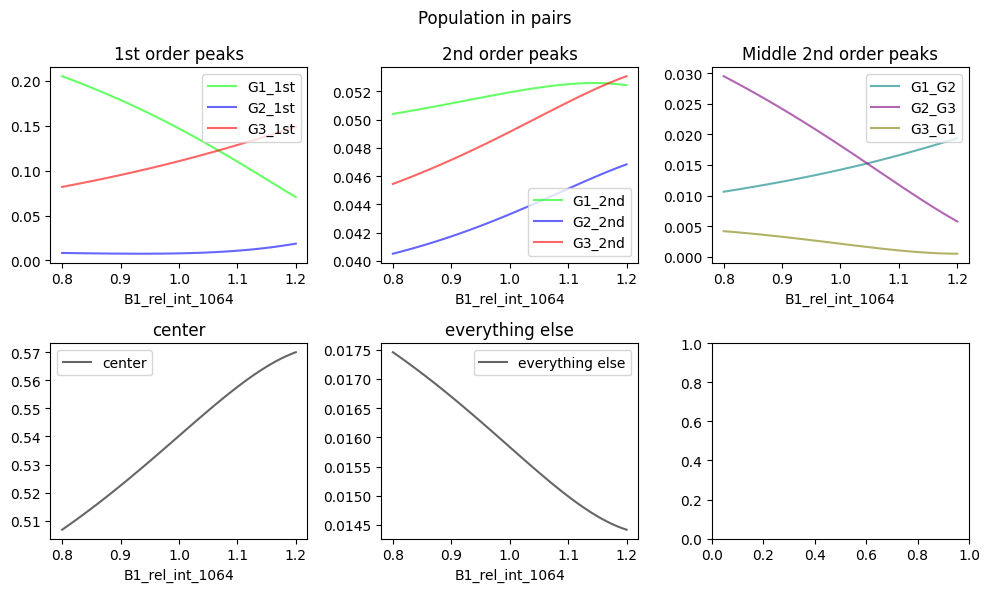

In [439]:
fig_pop, axs_pop = plt.subplots(2, 3, figsize = (10, 6))
for ax, title, str_pair_list in zip(axs_pop.flatten(),
    ("1st order peaks", "2nd order peaks", "Middle 2nd order peaks", "center", "everything else"),
    (["G1_1st", "G2_1st", "G3_1st"], ["G1_2nd", "G2_2nd", "G3_2nd"], ["G1_G2", "G2_G3", "G3_G1"], ["center"], ["everything else"])
    ):
    for str_pair in str_pair_list:
        color = dict_color_pairs[str_pair]

        pop_pair = [ls[str_pair] for ls in pop_in_pairs_list]
        # alpha < 1 to handle overlapping lines
        ax.plot(param_values, pop_pair, color = color, label = str_pair, alpha = 0.6)
        ax.legend()
        ax.set_xlabel(scan_param)
        ax.set_title(title)

fig_pop.suptitle("Population in pairs")
fig_pop.tight_layout()
# Fit for 1D superlattice
# popt, _ = curve_fit(Voigt_1D_pol, param_values, [ls["G3_1st"] for ls in pop_in_pairs_list],
#                     p0 = (np.pi / 2, 0.5, 0.5, -0.2, 0.4))
# fitted = Voigt_1D_pol(param_values, *popt)
# axs_pop[0, 0].plot(param_values, fitted, color = "black", ls = "--", label = "Voigt fit")

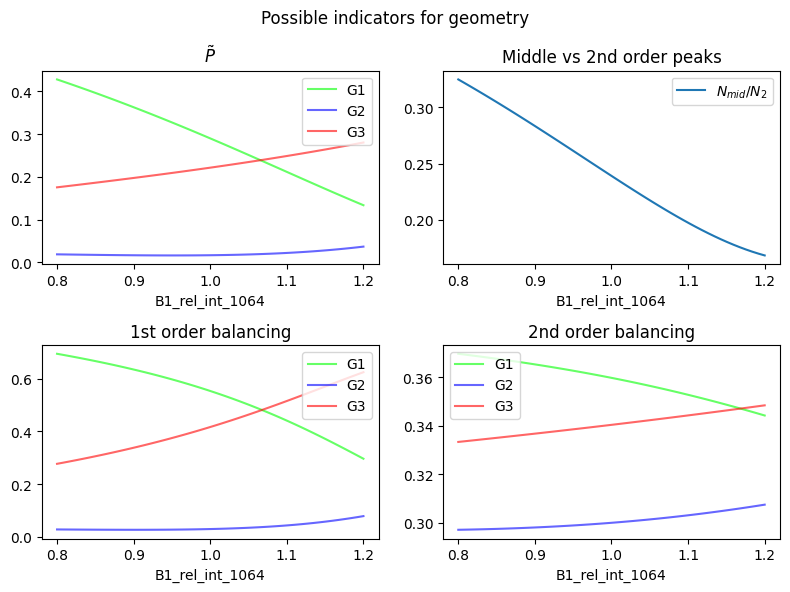

In [440]:
fig_ind, axs_ind = plt.subplots(2, 2, figsize = (8, 6))

# P tilde (in the first kagome paper)
for str_pair in ["G1", "G2", "G3"]:
    P_tilde = []
    for i, ls in enumerate(pop_in_pairs_list):
        p0 = ls["center"]
        p1 = ls[str_pair + "_1st"]
        p2 = ls[str_pair + "_2nd"]
        P_tilde.append((p1 / 2 / p0) * (2 * p0 / p2)**(1/4))
    color = dict_color_pairs[str_pair + "_1st"]
    axs_ind[0, 0].plot(param_values, P_tilde, color = color, label = str_pair, alpha = 0.6)
    axs_ind[0, 0].set_title(r"$\tilde{P}$")

# ratio of population in second order peaks
p_mid_ratio = []
for i, ls in enumerate(pop_in_pairs_list):
    p_2nd = ls["G1_2nd"] + ls["G2_2nd"] + ls["G3_2nd"]
    p_mid = ls["G1_G2"] + ls["G2_G3"] + ls["G3_G1"]
    p_mid_ratio.append(p_mid / p_2nd)
axs_ind[0, 1].plot(param_values, p_mid_ratio, label = r"$N_{mid} / N_2$")
axs_ind[0, 1].set_title("Middle vs 2nd order peaks")

# balancing (basically rescaling the band population plot above)
for i_o, str_order in enumerate(["1st", "2nd"]):
    pG1 = np.array([ls[f"G1_{str_order}"] for ls in pop_in_pairs_list])
    pG2 = np.array([ls[f"G2_{str_order}"] for ls in pop_in_pairs_list])
    pG3 = np.array([ls[f"G3_{str_order}"] for ls in pop_in_pairs_list])
    ptot = pG1 + pG2 + pG3
    for str_pair in ["G1", "G2", "G3"]:
        color = dict_color_pairs[str_pair + f"_{str_order}"]
        p_norm = eval(f"p{str_pair}") / ptot
        axs_ind[1, i_o].plot(param_values, p_norm, color = color, label = str_pair, alpha = 0.6)
        axs_ind[1, i_o].set_title(f"{str_order} order balancing")

for ax in axs_ind.flatten():
    ax.legend()
    ax.set_xlabel(scan_param)
fig_ind.suptitle("Possible indicators for geometry")
fig_ind.tight_layout()

### Visualize a particular Bloch state

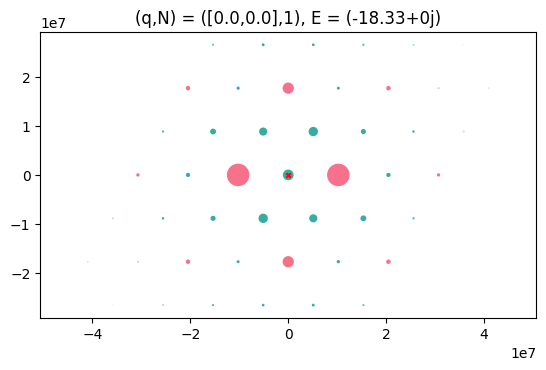

In [441]:
# ax_ToF = bsc.ToFSubplot(bsc.FindInStateList(e_states_ni[1], E9c.Kp*0.5, 1))
ax_ToF = bsc.ToFSubplot(e_states_ni[1][30])